# Assignment 02

Sabarno Saha, 22MS037.

## Problem 1

Repeat each simulation for different population sizes N=50, 100, 200, 300, 400, 600, 800,1000, 5000 
for N_T=100 trials.




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
# NJIT is needed, otherwise the complete double loop takes around 20 mins to run
from numba import njit


# Use the scienceplots package for nicer plot themes.
# import scienceplots
# plt.style.use(['science'])

# Just some config to make plots legible in pdfs
plt.rcParams.update({'font.size': 20,  'axes.labelweight': 'bold', 'font.family': 'sans-serif', 'legend.fontsize': 15})

In [2]:
# u1 rate of mutation from 0 to 1
# u2 rate of mutation from 1 to 0
u1 = 0.003
u2 = 0.001

# Number of generations required to equilibriate
T = 2000

# Population sizes
N = [50, 100, 200, 300, 400, 600, 800,1000, 5000 ]

# Number of Runs
NT = 100

In [3]:
# Generation of initial population
# Probability of A/B 
prob = 0.5


In [4]:
@njit
def mut_no_selection(T,N,pop_0,u1,u2):
    """
    Mutation without selection
    ---------
    Parameters:
    T: int
        number of generations
    N: int
        population size
    pop_0: array(Nx1)
        initial population size
    u1: float
        rate of change from one species to another
    u2: float
        rate of change from one species to another
    ---------    
    Returns:
    
    population: array(1xN)
        final population 
    frequencies: array(1x2)
        Final frequencies of A/B

    """
    population = np.zeros(N)
    frequencies = np.zeros(2)
    frequencies[0] = np.sum(pop_0)/N
    frequencies[1] = 1 - frequencies[0]
    population = pop_0.copy()
    for t in range(1,T):
        for i in range(N):
            if population[i] == 0:
                if np.random.rand() < u1:
                    population[i] = 1
                else:
                    population[i] = 0
            else:
                if np.random.rand() < u2:
                    population[i] = 0
                else:
                    population[i] = 1
        frequencies[0] = np.sum(population)/N
        frequencies[1] = 1 - frequencies[0]
    return population, frequencies
    

In [5]:
# This cell is completely unecessary,
# This cell is just here to ensure that numba compiles the function before the timed run

pop_0 = np.zeros(N[-1])
#ensuring half is A/B 
numA = int(prob*N[-1])
indices = np.random.choice(N[-1],numA, replace=False)
for i in indices:
    pop_0[i] =1
pops, freq = mut_no_selection(T,N[-1],pop_0,u1,u2)

In [6]:
%%time

# Mean and Variance arrays of A and B
# Since A and B are complementary, variance of A = variance of B
Variances = np.zeros((len(N),2))
Means = np.zeros((len(N),2))


# Loop over different population sizes
for n in range(len(N)):
    pop_0 = np.zeros(N[n])
    pop_0[:int(prob*N[n])] = 1
    print(f"Running for N={N[n]} with sum={np.sum(pop_0)}")
    
    # Loop over different runs
    for run in range(NT):
        pops, freq = mut_no_selection(T,N[n],pop_0,u1,u2)

        Means [n] += freq/NT
        Variances[n] += (freq**2)/NT
        
    Variances[n] -= Means[n]**2
    print(f"Means: {Means[n]}, Variances: {Variances[n]}")
    
        
        

Running for N=50 with sum=25.0
Means: [0.75 0.25], Variances: [0.004372 0.004372]
Running for N=100 with sum=50.0
Means: [0.7541 0.2459], Variances: [0.00213019 0.00213019]
Running for N=200 with sum=100.0
Means: [0.7525 0.2475], Variances: [0.00085925 0.00085925]
Running for N=300 with sum=150.0
Means: [0.75266667 0.24733333], Variances: [0.00047756 0.00047756]
Running for N=400 with sum=200.0
Means: [0.749475 0.250525], Variances: [0.00051666 0.00051666]
Running for N=600 with sum=300.0
Means: [0.74613333 0.25386667], Variances: [0.00024888 0.00024888]
Running for N=800 with sum=400.0
Means: [0.74985 0.25015], Variances: [0.00020788 0.00020788]
Running for N=1000 with sum=500.0
Means: [0.7502 0.2498], Variances: [0.00021084 0.00021084]
Running for N=5000 with sum=2500.0
Means: [0.749006 0.250994], Variances: [4.2567564e-05 4.2567564e-05]
CPU times: user 30.9 s, sys: 2.82 ms, total: 30.9 s
Wall time: 31.1 s


In [7]:
params, pcov = curve_fit(lambda x, a, b: a*x+b, 1/np.array(N), Variances[:,0])
perr = np.sqrt(np.diag(pcov))
print(f"Fitted parameters: {params}, with errors: {perr}")

Fitted parameters: [ 2.21311204e-01 -9.80119615e-05], with errors: [5.67105467e-03 4.42415532e-05]


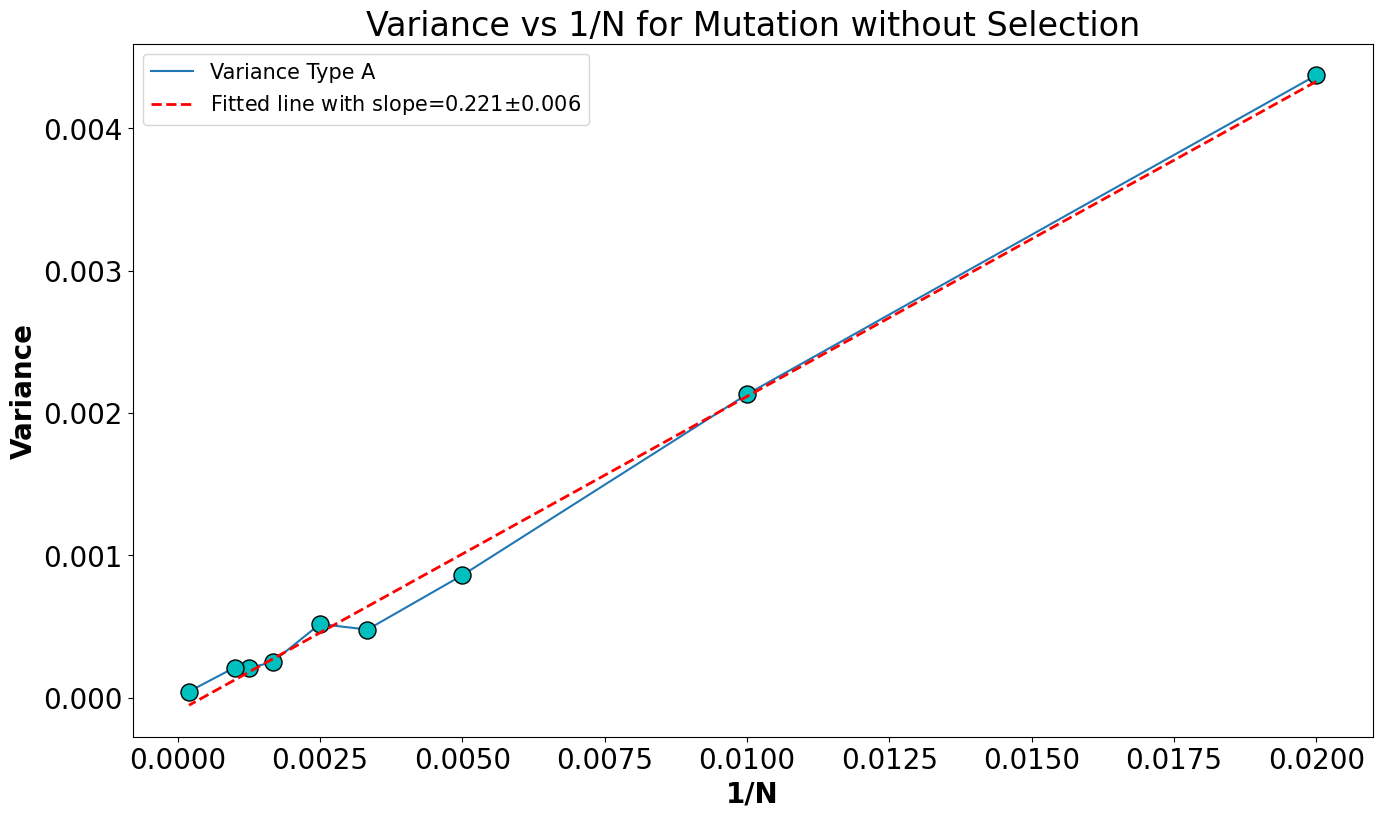

In [8]:
fig, axes = plt.subplots(figsize=(16,9))
# axes.plot(N, Means[:,0], label="Mean Type A", marker='o')
# axes.plot(N, Means[:,1], label="Mean Type B", marker='o')
axes.plot(1/np.array(N), Variances[:,0], label="Variance Type A", zorder=0 )
axes.scatter(1/np.array(N), Variances[:,0], color='c',marker='o',edgecolor='black',s=150)
axes.plot(1/np.array(N), params[0]*(1/np.array(N)) + params[1],c='r', label=f"Fitted line with slope={params[0]:.3f}" + r"$\pm$" + f"{perr[0]:.3f}", linestyle='--', lw=2)
axes.set_xlabel("1/N")
axes.set_ylabel("Variance")
axes.set_title("Variance vs 1/N for Mutation without Selection")
axes.legend()
# fig.savefig("images/variancefit.png", dpi=300)

## Problem 2

Moran Process neutral evolution.

In [9]:
# population size
N_moran = 500

# Half are A/B
prob_moran = 0.5

# Maximum number of generations(to prevent infinite loops)
T_max = int(1e6)

# Number of runs
Nt_moran = 100

In [10]:
@njit
def moran_neutral(pop,T):
    """
    moran_neutral 
    Returns a population updated by the Moran Process

    Parameters
    ----------
    pop : array
        Initial Population
    T : int
        Maximum Number of generations(to prevent infinite loops)
    """
    pop = np.asarray(pop)
    freq = np.zeros((T,2))
    freq[0,0] = np.sum(pop)/len(pop)
    freq[0,1] = 1 - freq[0,0]
    N = len(pop)
    for t in range(T):
        # Choose an individual to reproduce
        reproduce_idx = np.random.randint(0, N)
        # Choose an individual to die
        die_idx = np.random.randint(0, N)
        # Offspring replaces the dead individual
        pop[die_idx] = pop[reproduce_idx]
        
        # Update frequencies
        freq[t,0] = np.sum(pop)/N
        freq[t,1] = 1 - freq[t,0]
        
        # Check for fixation
        if freq[t,0] == 0 or freq[t,0] == 1:
            print(f"Fixation reached at generation {t}")
            # returns truncated frequency array
            return pop, freq[:t+1,:]
    print("Maximum generations reached without fixation")
    return pop, freq
        


In [11]:
pop_0 = np.zeros(N_moran)
#ensuring half is A/B 
numA = int(prob_moran*N_moran)
indices = np.random.choice(N_moran,numA, replace=False)
for i in indices:
    pop_0[i] =1

In [12]:
%%time
# This cell is not necessary,
# This cell is just here to ensure that numba compiles the function before the timed run
pop, freq = moran_neutral(pop_0,T_max)

Fixation reached at generation 278726
CPU times: user 1.34 s, sys: 46.5 ms, total: 1.39 s
Wall time: 1.52 s


In [13]:
%%time

fixation_probs = np.zeros(2)

for run in range(Nt_moran):
    pop_0 = np.zeros(N_moran)
    #ensuring half is A/B 
    numA = int(prob_moran*N_moran)
    indices = np.random.choice(N_moran,numA, replace=False)
    for i in indices:
        pop_0[i] =1
    
    # Run the Moran process
    pop, freq = moran_neutral(pop_0,T_max)
    fixation_probs += freq[-1]
  
# Normalize to get probabilities  
fixation_probs /= Nt_moran

Fixation reached at generation 275760
Fixation reached at generation 101132
Fixation reached at generation 49728
Fixation reached at generation 55459
Fixation reached at generation 167908
Fixation reached at generation 68835
Fixation reached at generation 84037
Fixation reached at generation 295564
Fixation reached at generation 53667
Fixation reached at generation 82178
Fixation reached at generation 680222
Fixation reached at generation 150855
Fixation reached at generation 262524
Fixation reached at generation 75818
Fixation reached at generation 77913
Fixation reached at generation 63969
Fixation reached at generation 73826
Maximum generations reached without fixation
Fixation reached at generation 33756
Fixation reached at generation 172576
Fixation reached at generation 180536
Fixation reached at generation 295701
Fixation reached at generation 50245
Fixation reached at generation 114489
Fixation reached at generation 147314
Fixation reached at generation 319057
Fixation reached 

Text(0.5, 1.0, 'Moran Process(Neutral Evolution): Frequency vs Generations')

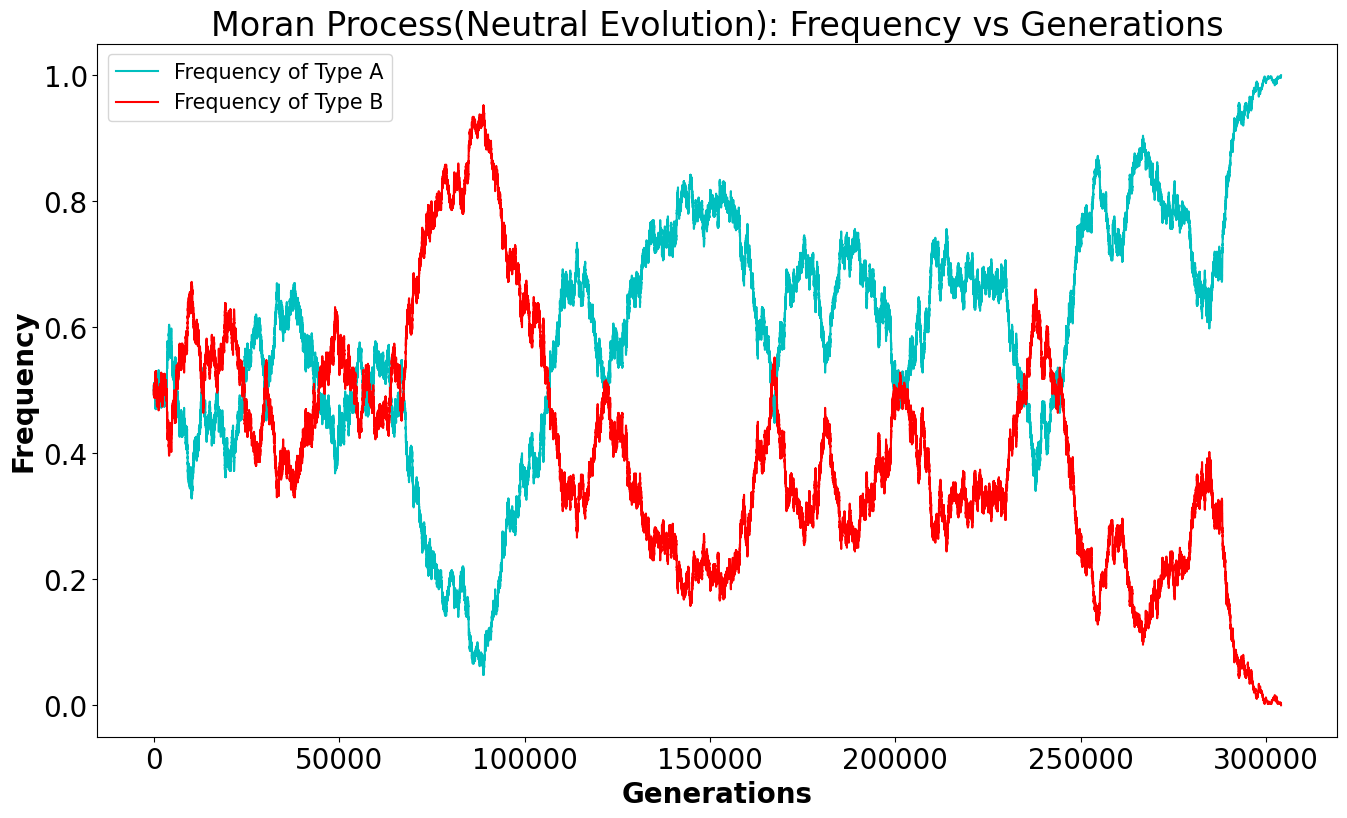

In [14]:
fig, axes = plt.subplots(figsize=(16,9))
axes.plot(freq[:,0], label="Frequency of Type A", color='c')
axes.plot(freq[:,1], label="Frequency of Type B", color='r')
axes.legend()
axes.set_xlabel("Generations")
axes.set_ylabel("Frequency")
axes.set_title("Moran Process(Neutral Evolution): Frequency vs Generations")
# fig.savefig("images/moranneutral.png", dpi=300)

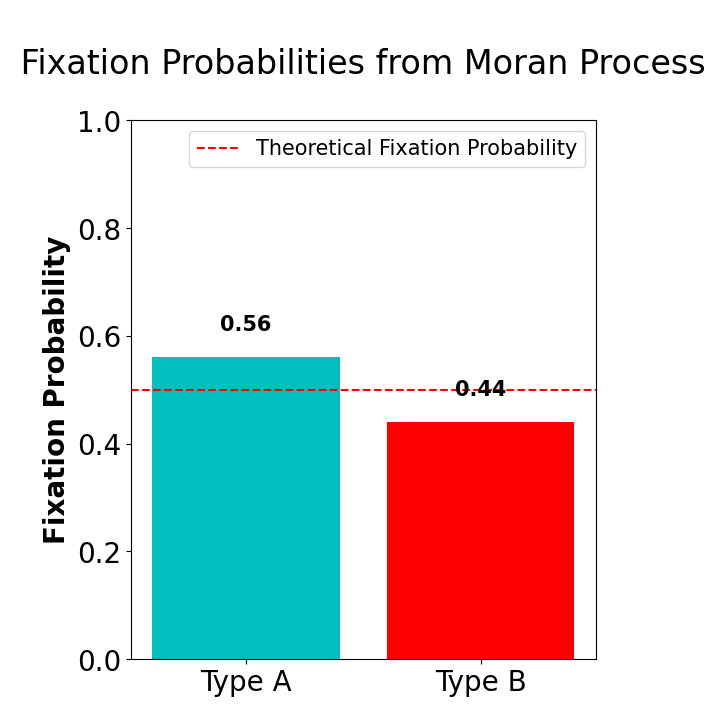

In [15]:
fig, axes = plt.subplots(figsize=(6,7))
axes.bar([0,1], fixation_probs, color=['c','r'])
axes.annotate(f"{fixation_probs[0]:.2f}", xy=(0, fixation_probs[0]), xytext=(0, fixation_probs[0]+0.05), ha='center', fontsize=15, fontweight='bold', color='black')
axes.annotate(f"{fixation_probs[1]:.2f}", xy=(1, fixation_probs[1]), xytext=(1, fixation_probs[1]+0.05), ha='center', fontsize=15, fontweight='bold', color='black')
axes.axhline(y=prob_moran, color='r', linestyle='--', label='Theoretical Fixation Probability')
axes.set_xticks([0,1])
axes.set_xticklabels(['Type A','Type B'])
axes.set_ylabel("Fixation Probability")
axes.set_ylim(0,1)
axes.set_title("\n Fixation Probabilities from Moran Process \n")
axes.legend()
# fig.savefig("images/moranneutral_fixation.png", dpi=300)
